<a href="https://colab.research.google.com/github/CwickHolmesalot/PowerDensity_AAPG2024/blob/main/AAPG02_DataEngineering_FieldScale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rethinking Power Density for Geothermal Resource Estimation<br>
## Script 2: Data engineering for field-scale predictive modeling<br>
Author: Chad Holmes<br>
Date: December 2024

### load libraries

In [ ]:
!pip install rasterio tqdm jenkspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.9/650.9 kB 31.2 MB/s eta 0:00:00


In [ ]:
# load libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import pickle as pkl
import urllib.parse
import requests
import time
import gc
import jenkspy
import rasterio
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

### mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### load data

In [ ]:
path = r'drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG'
dirpath = Path(path)

In [ ]:
# define file locations
geofile = dirpath / 'Input' / 'PowerDensityPlot.xlsx'
kmlfile = dirpath / 'Input' / 'Geothermal Power Plants KML.xlsx'
dbfile  = dirpath / 'Input' / 'GPPD_geothermal.xlsx'
rysfile = dirpath / 'Input' / 'Ry_Tectonics_Matched.xlsx'
ecmfile = dirpath / 'Input' / 'ECM1.txt'
hffile  = dirpath / 'Input' / 'HFgrid14.csv'
gctfile = dirpath / 'Input' / 'ECM_Hcc_0p25deg_THG.csv'

# extract data from WorldClim
tminstem = 'wc2.1_30s_tmin'
tmaxstem = 'wc2.1_30s_tmax'
tavgstem = 'wc2.1_30s_tavg'
precstem = 'wc2.1_30s_prec'

In [ ]:
# load data
pd_orig  = pd.read_excel(geofile)
kml_orig = pd.read_excel(kmlfile)
gdf_orig = pd.read_excel(dbfile)
rys_orig = pd.read_excel(rysfile)
ecm_orig = pd.read_csv(ecmfile,delimiter='\t')
hf_orig = pd.read_csv(hffile,delimiter=';')
gct_orig = pd.read_csv(gctfile,sep='\s+')

pd_orig.head()

,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime
0,Oguni,225.0,0.864198,Arcs
1,Suginoi,210.0,1.234568,Arcs
2,Mataloko,240.0,2.345679,Arcs
3,Hachijojima,300.0,2.469136,Arcs
4,Sibayak,280.0,2.530864,Arcs


### First-pass Filtering and Data Cleaning

In [ ]:
# filter out unlabeled power plants from Wilmarth et al.'s plot
pd_orig = pd_orig[pd_orig.Name != 'Unknown']
pd_orig.shape

(100, 4)

In [ ]:
# drop power plants that are not a match to base data set
rys_orig = rys_orig[rys_orig.MatchName.isna() == False]

# restrict to power-generating hydrothermal systems
rys_conv = rys_orig[rys_orig['Asset purpose']      == 'Power generation']
rys_conv = rys_conv[(rys_orig['Subsurface system'] == 'Hydrothermal')]

In [ ]:
rys_conv['Subsurface system'].value_counts()

,count
Subsurface system,
Hydrothermal,410


In [ ]:
# select fields of interest from Rystad data
keepcols = ['Country', 'Asset', 'MatchName', 'RystadLatitude', 'RystadLongitude', #'Subsurface system',
            'Technology', 'Temperature', 'Reservoir temperature (°C)', 'Startup year',
            'Installed capacity (MWe)', 'Production wells', 'Total wells',
            'Drilling length group (meters)', 'MW per well', 'PowerPerWell']

# sort conventional geothermal plants by start year
rys_conv = rys_conv.sort_values(by='Startup year', ascending=True)

# update data types
rys_conv['Production wells'] = rys_conv['Production wells'].astype(int)
rys_conv['Total wells']      = rys_conv['Total wells'].astype(int)
rys_conv['Startup year']     = rys_conv['Startup year'].astype(float)
rys_conv['Reservoir temperature (°C)'] = rys_conv['Reservoir temperature (°C)'].astype(float)
rys_conv['Installed capacity (MWe)']   = rys_conv['Installed capacity (MWe)'].astype(float)
rys_conv['MW per well']      = rys_conv['MW per well'].astype(float)

In [ ]:
# Calculate average power produced per production well based on installed capacity (net capacity is underdefined)
rys_conv['PowerPerWell'] = [a/b for a,b in zip(rys_conv['Installed capacity (MWe)'],rys_conv['Production wells'])]

In [ ]:
# calculates the mode of a categorical data feature
def determine_categorical_mode(a):
    cnts = a.value_counts()
    return cnts.index[cnts.argmax()]

In [ ]:
# Define the order of the categories
temp_order = ['<50 °C','50-100 °C','100-150 °C','150-200 °C','200-250 °C','250+ °C']

# Convert the column to an ordered categorical variable
rys_conv['Temperature'] = rys_conv['Temperature'].astype(CategoricalDtype(categories=temp_order, ordered=True))

rys_conv['Drilling length group (meters)'] = rys_conv['Drilling length group (meters)'].replace({'0-500 meters':'a. 0-500 meters',
                                                                      '500-1,000 meters':'b. 500-1,000 meters',
                                                                      '1,000-1,500 meters':'c. 1,000-1,500 meters',
                                                                      '1,500-2,000 meters':'d. 1,500-2,000 meters',
                                                                      '2,000-2,500 meters':'e. 2,000-2,500 meters',
                                                                      '2,500-3,000 meters':'f. 2,500-3,000 meters',
                                                                      '3,000-3,500 meters':'g. 3,000-3,500 meters',
                                                                      '3,500-4,000 meters':'h. 3,500-4,000 meters',
                                                                      '4,000-4,500 meters':'i. 4,000-4,500 meters',
                                                                      '4,500-5,000 meters':'j. 4,500-5,000 meters',
                                                                      '5,000-5,500 meters':'k. 5,000-5,500 meters',
                                                                      '5,500-6,000 meters':'l. 5,500-6,000 meters',
                                                                      '6,000+ meters':     'm. 6,000-6,500 meters'})

# Define the order of the categories
depth_order = ['a. 0-500 meters',      'b. 500-1,000 meters',
               'c. 1,000-1,500 meters','d. 1,500-2,000 meters',
               'e. 2,000-2,500 meters','f. 2,500-3,000 meters',
               'g. 3,000-3,500 meters','h. 3,500-4,000 meters',
               'i. 4,000-4,500 meters','j. 4,500-5,000 meters',
               'k. 5,000-5,500 meters','l. 5,500-6,000 meters',
               'm. 6,000-6,500 meters']

# Convert the column to an ordered categorical variable
rys_conv['Drilling length group (meters)'] = rys_conv['Drilling length group (meters)'].astype(CategoricalDtype(categories=depth_order, ordered=True))

# Display the resulting DataFrame
# print(rys_conv['Drilling length group (meters)'])

In [ ]:
rys_conv.Technology.value_counts()

,count
Technology,
Flash,217
Binary,106
Dry steam,78
Hybrid,6
Flash and binary,3


In [ ]:
# mass aggregation of Rystad data set to match Wilmarth et al. plot
keepcols = [c for c in keepcols if c != 'Technology']
rys_agg = rys_conv[keepcols].groupby(['MatchName']).aggregate({'Country':'first',
                                                               'Asset':'first',
                                                               'RystadLatitude':'mean',
                                                               'RystadLongitude':'mean',
                                                               'Temperature':determine_categorical_mode,
                                                               'Reservoir temperature (°C)':'mean',
                                                               'Startup year':'min',
                                                               'Installed capacity (MWe)':'sum',
                                                               'Production wells':'sum',
                                                               'Total wells':'sum',
                                                               'Drilling length group (meters)':determine_categorical_mode,
                                                               'MW per well':'mean',
                                                               'PowerPerWell':'mean'}).reset_index(drop=False)

In [ ]:
# quickly screen out power plants that are new or planned
rys_agg = rys_agg[rys_agg['Startup year'] <= 2022]
rys_agg.shape

(100, 14)

### Get elevations from OpenTopoData

In [ ]:
def get_all_elevations(lat, lon):
    locs = [f"{l1},{l2}" for l1,l2 in zip(lat,lon)]
    locstr = '|'.join(locs)
    print(locstr)
    base_url = "https://api.opentopodata.org/v1/etopo1?"
    params = {
        "locations": locstr,
        "nodata_value": -9999
    }
    response = requests.get(base_url + urllib.parse.urlencode(params))
    print(response)
    data = response.json()
    print(data)
    time.sleep(1)
    return data['results'][0]['elevation']

def get_elevation(lat, lon):
    base_url = "https://api.opentopodata.org/v1/etopo1?"
    params = {
        "locations": f"{lat},{lon}",
        "nodata_value": -9999
    }
    response = requests.get(base_url + urllib.parse.urlencode(params))
    data = response.json()
    print(data)
    time.sleep(1)
    return data['results'][0]['elevation']

In [ ]:
# extract elevations
kml_topo = kml_orig[kml_orig.InWSPlot==True]
kml_topo.loc[:,'Elevation'] = [get_elevation(lat,lon) for lat,lon in zip(kml_topo.Latitude, kml_topo.Longitude)]

# aggregate locations and topography
kml_topo = kml_topo.groupby('MatchName').aggregate({'Country':'first','PowerPlant':'first','Latitude':'mean','Longitude':'mean','Elevation':'mean'})
kml_topo.head(50)

{'results': [{'dataset': 'etopo1', 'elevation': 798.0, 'location': {'lat': 13.9201595259298, 'lng': -89.8171761325335}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 1223.0, 'location': {'lat': 40.3009100227308, 'lng': -120.194903434064}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 159.0, 'location': {'lat': 37.80135537016, 'lng': -25.5053947446847}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 629.0, 'location': {'lat': 13.0547190321669, 'lng': 123.967560025956}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 564.0, 'location': {'lat': 13.0599306181687, 'lng': 123.929582995473}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 745.0, 'location': {'lat': 13.0348575260683, 'lng': 123.93730936974}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'elevation': 1511.0, 'location': {'lat': 40.5548292885136, 'lng': -116.617000480228}}], 'status': 'OK'}
{'results': [{'dataset': 'etopo1', 'el

<ipython-input-18-d9402b91e90f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kml_topo.loc[:,'Elevation'] = [get_elevation(lat,lon) for lat,lon in zip(kml_topo.Latitude, kml_topo.Longitude)]


,Country,PowerPlant,Latitude,Longitude,Elevation
MatchName,,,,,
Ahuachapan,Central_America,Ahuachapan,13.920160,-89.817176,798.000000
Amedee,US-Canada,Amedee,40.300910,-120.194903,1223.000000
Azores,Iceland-Hawaii-Azores,Pico Vermelho,37.801355,-25.505395,159.000000
BacMan,Philippines,Bacman a,13.049836,123.944817,646.000000
Beowawe,US-Canada,Beowawe,40.554829,-116.617000,1511.000000
Blue Mountain,US-Canada,Blue Mtn,40.995143,-118.142756,1300.000000
Blundell,US-Canada,Roosevelt,38.488826,-112.853004,1852.000000
Bouillante,Caribbean,La Bouillante,16.127205,-61.769062,82.000000
Bradys,US-Canada,Bradys flash,39.795915,-119.009404,1273.000000


### First merge

In [ ]:
# merge power density plot data with lat/long info from kml file
combodf = pd.merge(left=pd_orig, right=kml_topo, how='left',left_on='Name',right_on='MatchName')
combodf = combodf.drop([c for c in combodf.columns if 'xx_' in c],axis=1)

# save out results as intermediate output
combodf.to_excel(dirpath / 'Output' / 'pd_kml_combo_FIELDS.xlsx')

print(combodf.shape)
combodf.head(10)

(100, 9)


,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime,Country,PowerPlant,Latitude,Longitude,Elevation
0,Oguni,225.0,0.864198,Arcs,Japan,Oguni,33.138653,131.147106,973.0
1,Suginoi,210.0,1.234568,Arcs,Japan,Suginoi Hotel,33.281659,131.468192,320.5
2,Mataloko,240.0,2.345679,Arcs,Indonesia_PapuaNG,Mataloko,-8.833641,121.060828,1038.0
3,Hachijojima,300.0,2.469136,Arcs,Japan,Hachijojima,33.074797,139.812391,256.0
4,Sibayak,280.0,2.530864,Arcs,Indonesia_PapuaNG,Sibayak,3.227134,98.513641,1604.0
5,Onikobe,235.0,3.148148,Arcs,Japan,Onikobe,38.809768,140.708730,598.0
6,Onuma,225.0,3.641975,Arcs,Japan,Ohnuma,39.985779,140.805054,963.0
7,Karaha-Telaga Bodas,290.0,5.802469,Arcs,Indonesia_PapuaNG,Karaha-Telaga Bodas,-7.180120,108.074199,1440.0
8,Uenotai,310.0,5.802469,Arcs,Japan,Uenotai,39.001512,140.603915,681.0
9,Yamakawa,305.0,6.111111,Arcs,Japan,Yamakawa,31.190653,130.614479,24.0


### Second merge

In [ ]:
# remove extra columns from GPPDB
keep_cols = ['country','country_long','MatchName','Name','capacity_mw','latitude','longitude','commissioning_year','owner','estimated_generation_gwh_2017']
gdf_edit = gdf_orig[gdf_orig.InPowerDensityPlot==True][keep_cols]

# clear out whitespace from MatchName
gdf_edit.loc[:,'MatchName'] = gdf_edit.MatchName.apply(str.strip)

# rename columns
new_col_names = ['CountryShort','CountryLong','MatchName','GPPDBName','NameplateCapacity','GPPDBLatitude','GPPDBLongitude','FirstCommissionYear','Owner','EstGenerationPerYear']
gdf_edit.columns = new_col_names

# sort on commissioning year
gdf_edit.sort_values(by='FirstCommissionYear',inplace=True)

print(gdf_edit.shape)
gdf_edit.head()

(153, 10)


,CountryShort,CountryLong,MatchName,GPPDBName,NameplateCapacity,GPPDBLatitude,GPPDBLongitude,FirstCommissionYear,Owner,EstGenerationPerYear
107,NZL,New Zealand,Wairakei-Tauhara,Wairakei,132.0,-38.6266,176.1055,1958.0,Contact Energy,985.76
72,JPN,Japan,Matsukawa,Matsukawa Geothermal,23.5,39.9271,140.9333,1966.0,TOHOKU ELECTRIC POWER CO,105.85
77,JPN,Japan,Otake,Otake,12.5,33.1217,131.1902,1967.0,KYUSHU ELECTRIC POWER CO,56.30
76,JPN,Japan,Onuma,Onuma Plant,9.5,39.9813,140.7819,1973.0,HOKKAIDO ELECTRIC POWER CO INC,42.79
91,MEX,Mexico,Cerro Prieto,Cerro Prieto,820.0,32.3916,-115.2252,1973.0,CFE,5396.00


In [ ]:
# aggregate on MatchName
gdf = gdf_edit.groupby("MatchName").aggregate({'CountryShort':'first',
                                               'CountryLong':'first',
                                               'GPPDBName':'first',
                                               'NameplateCapacity':'sum',
                                               'GPPDBLatitude':'mean',
                                               'GPPDBLongitude':'mean',
                                               'FirstCommissionYear':'min',
                                               'Owner':'first',
                                               'EstGenerationPerYear':'sum'}).reset_index(drop=False)
combodf2 = pd.merge(left=combodf, right=gdf, how='outer',left_on='Name',right_on='MatchName')

# save out results as intermediate output
combodf2.to_excel(dirpath / 'Output' / 'pd_kml_gppdb_combo_FIELDS.xlsx')
combodf2.shape

(100, 19)

### Third merge

In [ ]:
# aggregate on MatchName
combodf3 = pd.merge(left=combodf2, right=rys_agg, how='outer',left_on='Name',right_on='MatchName')
combodf3.to_excel(dirpath / 'Output' / 'pd_kml_gppdb_rys_combo_FIELDS.xlsx')
combodf3.shape

(100, 33)

In [ ]:
# check that number of field names is consistent
print(len(combodf3.MatchName_x.unique()),len(combodf3.MatchName_y.unique()))

100 100


### filter the data based on start/commission year

In [ ]:
# combine various year columns into one "truth"
combodf3['FirstCommissionYear'] = combodf3['FirstCommissionYear'].fillna(9999)
combodf3['Startup year'] = combodf3['Startup year'].fillna(9999)
combodf3['EstFirstYear'] = [min(int(y1),int(y2)) for y1,y2 in zip(combodf3['FirstCommissionYear'],combodf3['Startup year'])]

# focus on plants commissioned no later than 2022
gdf = combodf3[combodf3['EstFirstYear'] <= 2022]

# check that we still have the same number of unique fields
print(gdf.shape, gdf.Name.nunique())

(100, 34) 100


In [ ]:
gdf.columns

Index(['Name', 'WS_Temp', 'WS_PowerDensity', 'WS_TectonicRegime', 'Country_x',
       'PowerPlant', 'Latitude', 'Longitude', 'Elevation', 'MatchName_x',
       'CountryShort', 'CountryLong', 'GPPDBName', 'NameplateCapacity',
       'GPPDBLatitude', 'GPPDBLongitude', 'FirstCommissionYear', 'Owner',
       'EstGenerationPerYear', 'MatchName_y', 'Country_y', 'Asset',
       'RystadLatitude', 'RystadLongitude', 'Temperature',
       'Reservoir temperature (°C)', 'Startup year',
       'Installed capacity (MWe)', 'Production wells', 'Total wells',
       'Drilling length group (meters)', 'MW per well', 'PowerPerWell',
       'EstFirstYear'],
      dtype='object')

### Grab climate values from geotiffs

In [ ]:
def get_clim_value(stem,latlondf):

    values = np.zeros(latlondf.shape[0])

    # build path
    tifpath = dirpath / 'Input' / (stem + '_summary.tif')
    print(f'opening tif file: {tifpath}')

    # open the climate normals data set
    with rasterio.open(tifpath) as src:

        # for each location in the input dataframe
        for k in range(latlondf.shape[0]):

            lat,lon = latlondf.iloc[k,0],latlondf.iloc[k,1]

            # Use the `index` function to find the indices of the given latitude and longitude
            row, col = src.index(lon,lat)

            # Use these indices to read the corresponding pixel value from the dataset
            v = src.read(1)[row, col]
            print(k,lat,lon,v)
            values[k] = v

    return values

In [ ]:
# average temperature
gdf.loc[:,'WorldClim_AvgTemp'] = get_clim_value(tavgstem,gdf[['Latitude','Longitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_tavg_summary.tif
0 13.9201595259298 -89.8171761325335 23.074999
1 40.3009100227308 -120.194903434064 9.983333
2 37.80135537016 -25.5053947446847 17.066668
3 13.049835725467966 123.944817463723 23.491667
4 40.5548292885136 -116.617000480228 9.591666
5 40.9951430092967 -118.142755594725 10.466666
6 38.4888256468502 -112.853003951582 9.391666
7 16.1272054141903 -61.7690616794216 -999.0
8 39.7959145933895 -119.009403960393 11.758332
9 32.402017567832175 -115.23007718303175 22.35
10 65.0530832111356 -146.056663732165 -4.433334
11 36.01631611334098 -117.79750753448775 16.058332
12 -7.21674629325857 107.7324404683045 14.183333
13 39.75411244732 -118.953389061674 11.624999
14 -7.22640901299321 109.897662498048 14.400001
15 39.9672453043261 -117.85591473999 11.991666
16 21.1847883184437 -104.725634005348 19.691668
17 38.8373047038786 -118.323799461259 11.975001
18 32.81552 -115.256741 23.0
19 19.96465555563

In [ ]:
# min temperature
gdf.loc[:,'WorldClim_MinTemp'] = get_clim_value(tminstem,gdf[['Latitude','Longitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_tmin_summary.tif
0 13.9201595259298 -89.8171761325335 15.7
1 40.3009100227308 -120.194903434064 -6.2
2 37.80135537016 -25.5053947446847 11.2
3 13.049835725467966 123.944817463723 18.6
4 40.5548292885136 -116.617000480228 -8.2
5 40.9951430092967 -118.142755594725 -7.5
6 38.4888256468502 -112.853003951582 -9.2
7 16.1272054141903 -61.7690616794216 -3.4e+38
8 39.7959145933895 -119.009403960393 -6.2
9 32.402017567832175 -115.23007718303175 7.2
10 65.0530832111356 -146.056663732165 -28.7
11 36.01631611334098 -117.79750753448775 -0.5
12 -7.21674629325857 107.7324404683045 9.2
13 39.75411244732 -118.953389061674 -6.1
14 -7.22640901299321 109.897662498048 8.4
15 39.9672453043261 -117.85591473999 -6.7
16 21.1847883184437 -104.725634005348 6.0
17 38.8373047038786 -118.323799461259 -6.9
18 32.81552 -115.256741 4.6
19 19.964655555635048 99.1552951050559 12.2
20 37.87507461233903 27.5974220794847 4.0
21 33.07479

In [ ]:
# max temperature
gdf.loc[:,'WorldClim_MaxTemp'] = get_clim_value(tmaxstem,gdf[['Latitude','Longitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_tmax_summary.tif
0 13.9201595259298 -89.8171761325335 30.3
1 40.3009100227308 -120.194903434064 32.5
2 37.80135537016 -25.5053947446847 25.0
3 13.049835725467966 123.944817463723 28.5
4 40.5548292885136 -116.617000480228 33.4
5 40.9951430092967 -118.142755594725 33.8
6 38.4888256468502 -112.853003951582 32.5
7 16.1272054141903 -61.7690616794216 -3.4e+38
8 39.7959145933895 -119.009403960393 34.6
9 32.402017567832175 -115.23007718303175 39.1
10 65.0530832111356 -146.056663732165 22.3
11 36.01631611334098 -117.79750753448775 36.2
12 -7.21674629325857 107.7324404683045 18.4
13 39.75411244732 -118.953389061674 34.4
14 -7.22640901299321 109.897662498048 19.3
15 39.9672453043261 -117.85591473999 35.4
16 21.1847883184437 -104.725634005348 32.3
17 38.8373047038786 -118.323799461259 35.6
18 32.81552 -115.256741 43.0
19 19.964655555635048 99.1552951050559 34.2
20 37.87507461233903 27.5974220794847 34.7
21 33.

In [ ]:
# average precipitation
gdf.loc[:,'WorldClim_AvgPrec'] = get_clim_value(precstem,gdf[['Latitude','Longitude']])

opening tif file: drive/MyDrive/Colab Notebooks/PowerDensity/Papers/AAPG/Input/wc2.1_30s_prec_summary.tif
0 13.9201595259298 -89.8171761325335 144
1 40.3009100227308 -120.194903434064 26
2 37.80135537016 -25.5053947446847 82
3 13.049835725467966 123.944817463723 278
4 40.5548292885136 -116.617000480228 19
5 40.9951430092967 -118.142755594725 17
6 38.4888256468502 -112.853003951582 24
7 16.1272054141903 -61.7690616794216 0
8 39.7959145933895 -119.009403960393 12
9 32.402017567832175 -115.23007718303175 4
10 65.0530832111356 -146.056663732165 23
11 36.01631611334098 -117.79750753448775 15
12 -7.21674629325857 107.7324404683045 270
13 39.75411244732 -118.953389061674 12
14 -7.22640901299321 109.897662498048 261
15 39.9672453043261 -117.85591473999 13
16 21.1847883184437 -104.725634005348 102
17 38.8373047038786 -118.323799461259 10
18 32.81552 -115.256741 6
19 19.964655555635048 99.1552951050559 109
20 37.87507461233903 27.5974220794847 59
21 33.0747968888037 139.812391175833 217
22 33.10

In [ ]:
gdf.columns

Index(['Name', 'WS_Temp', 'WS_PowerDensity', 'WS_TectonicRegime', 'Country_x',
       'PowerPlant', 'Latitude', 'Longitude', 'Elevation', 'MatchName_x',
       'CountryShort', 'CountryLong', 'GPPDBName', 'NameplateCapacity',
       'GPPDBLatitude', 'GPPDBLongitude', 'FirstCommissionYear', 'Owner',
       'EstGenerationPerYear', 'MatchName_y', 'Country_y', 'Asset',
       'RystadLatitude', 'RystadLongitude', 'Temperature',
       'Reservoir temperature (°C)', 'Startup year',
       'Installed capacity (MWe)', 'Production wells', 'Total wells',
       'Drilling length group (meters)', 'MW per well', 'PowerPerWell',
       'EstFirstYear', 'WorldClim_AvgTemp', 'WorldClim_MinTemp',
       'WorldClim_MaxTemp', 'WorldClim_AvgPrec'],
      dtype='object')

In [ ]:
# search for bad values
gdf[gdf.WorldClim_AvgTemp == -999].loc[:,['Name','CountryLong','Asset']]

,Name,CountryLong,Asset
7,Bouillante,Guadeloupe,"La Bouillante 1, GP"
36,Lihir,Papua New Guinea,"Lihir 1, PG"
72,Reykjanes,Iceland,"Reykjanes 1, IS"


In [ ]:
# fill in values for locations that failed during look0-ups
gdf = gdf.reset_index().set_index('Name')

# Lihir
gdf.loc['Lihir','Elevation'] = 5
gdf.loc['Lihir','WorldClim_AvgTemp'] = 27.5
gdf.loc['Lihir','WorldClim_MinTemp'] = 24.4
gdf.loc['Lihir','WorldClim_MaxTemp'] = 31.7
gdf.loc['Lihir','WorldClim_AvgPrec'] = 215.6

# Bouillante
gdf.loc['Bouillante','Elevation'] = 10.4
gdf.loc['Bouillante','WorldClim_AvgTemp'] = 28.2
gdf.loc['Bouillante','WorldClim_MinTemp'] = 18.6
gdf.loc['Bouillante','WorldClim_MaxTemp'] = 30.3
gdf.loc['Bouillante','WorldClim_AvgPrec'] = 78.6

# Reykjanes
gdf.loc['Reykjanes','Elevation'] = 27.4
gdf.loc['Reykjanes','WorldClim_AvgTemp'] = 5.2
gdf.loc['Reykjanes','WorldClim_MinTemp'] = -2.2
gdf.loc['Reykjanes','WorldClim_MaxTemp'] = 13.9
gdf.loc['Reykjanes','WorldClim_AvgPrec'] = 24.5

# range in temperature
gdf.loc[:,'WorldClim_TempRange'] = [mx-mn for mx,mn in zip(gdf.WorldClim_MaxTemp,gdf.WorldClim_MinTemp)]

In [ ]:
gdf.shape

(100, 39)

In [ ]:
# make sure index is reset
gdf = gdf.drop('index',axis=1).reset_index(drop=False)

In [ ]:
# final check for bad values
gdf[gdf.WorldClim_AvgTemp == -999].loc[:,['Name','CountryLong','Asset']]

,Name,CountryLong,Asset


### some final data engineering

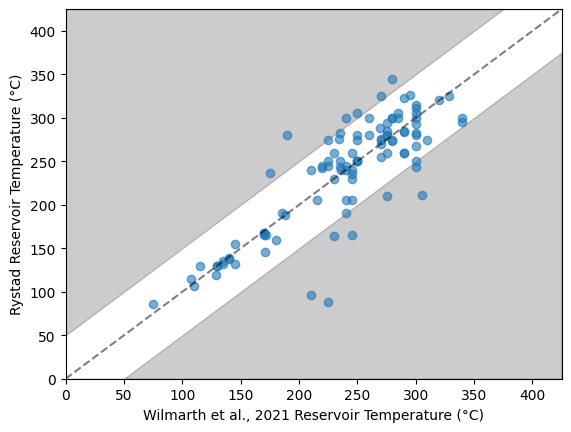

In [ ]:
# check reservoir temperature values
# comparison of Wilmarth et al. temps with temp data from Rystad

xlim = [0,425]
ylim = xlim
x = np.arange(xlim[0],xlim[1],0.1)
plt.plot(x, x,
         c='black',
         linestyle='dashed',
         alpha = 0.5)

# Fill the area where values differ by no more than 50 degrees C with white
plt.fill_between(x, x-50, x+50, color='white', alpha=0.1)

# Fill the areas above and below this central zone with gray
plt.fill_between(x, ylim[0], x-50, color='black', alpha=0.2)
plt.fill_between(x, x+50, ylim[1], color='black', alpha=0.2)

plt.scatter(gdf['WS_Temp'],
            gdf['Reservoir temperature (°C)'],
            alpha=0.6)
plt.xlim(xlim)
plt.ylim(ylim)

# plt.title('Reservoir Temperature from Different Sources')
plt.xlabel('Wilmarth et al., 2021 Reservoir Temperature (°C)')
plt.ylabel('Rystad Reservoir Temperature (°C)')

plt.show()

In [ ]:
# identify fields that show temperature difference of 50 degrees or more
rtdiff = gdf
rtdiff.loc[:,'Temp Difference'] = [abs(w-r) for w,r in zip(gdf.WS_Temp,gdf['Reservoir temperature (°C)'])]
print(rtdiff[rtdiff['Temp Difference'] >=50].Name.unique())

# save off list to include in paper
rtdiff = rtdiff[rtdiff['Temp Difference'] >=50].loc[:,['Name','WS_Temp','Reservoir temperature (°C)','Temp Difference']]
rtdiff.to_excel(dirpath / 'Output' / 'rtdiff_FIELDS.xlsx')

['Dixie Valley' 'Krafla' 'Lahendong' 'Matsukawa' 'Oguni' 'Olkaria' 'Onuma'
 'Palinpinon' 'Pauzhetskaya' 'Suginoi' 'Takigami' 'The Geysers' 'Travale'
 'Wairakei-Tauhara' 'Yamakawa' 'Yangbajing']


In [ ]:
# start with Wilmarth et al. temperature values
gdf['PDTemp_Edited'] = gdf['WS_Temp']
gdf = gdf.drop(['Temp Difference'],axis=1)

# replace with updated values based on literature
gdf = gdf.set_index('Name')
gdf.loc['Blundell','PDTemp_Edited']         = 245 # Allis and Larsen, 2012
gdf.loc['Dieng','PDTemp_Edited']            = 300 # Shalihin et al., 2002
gdf.loc['Dixie Valley','PDTemp_Edited']     = 245 # Bergfeld, 2001
gdf.loc['Krafla','PDTemp_Edited']           = 300 # secondary zone (below 1400m), Ntihabose, 2014
gdf.loc['Lahendong','PDTemp_Edited']        = 300 # Utami et al., 2004
gdf.loc['Matsukawa','PDTemp_Edited']        = 250 # Hanano, 1994
gdf.loc['Oguni','PDTemp_Edited']            = 230 # Nakanishi et al., 1995
gdf.loc['Olkaria','PDTemp_Edited']          = 275 # Ofwona et al, 2000
gdf.loc['Onuma','PDTemp_Edited']            = 230 # Ariki and Kawakami, 2000
gdf.loc['Palinpinon','PDTemp_Edited']       = 300 # D'Amore et al., 1993
gdf.loc['Pauzhetskaya','PDTemp_Edited']     = 190 # Kiryukhin et al., 2006
gdf.loc['Salak West','PDTemp_Edited']       = 280 # (240-316) Peter, 2015
gdf.loc['Suginoi','PDTemp_Edited']          = 210 # Kudo et al, 1996, Hirakawa, 1983
gdf.loc['Takigami','PDTemp_Edited']         = 240 # Furuya, 1988
gdf.loc['The Geysers','PDTemp_Edited']      = 235 # Peacock, 2019
gdf.loc['Travale','PDTemp_Edited']          = 325 # (300-350) Bertani et al., 2005
gdf.loc['Wairakei-Tauhara','PDTemp_Edited'] = 255 # balance of Wairakei (below 255) and Tauhara (max 275) McDowell, 2020; Ciraiaco, 2020
gdf.loc['Yamakawa','PDTemp_Edited']         = 300 # Akaku et al., 1991
gdf.loc['Yangbajing','PDTemp_Edited']       = 250 # deeper reservoir, Ji and Ping, 2000
gdf = gdf.reset_index(drop=False)

# trust edited values over Rystad aggregates
gdf.loc[:,'Reservoir temperature (°C)'] = gdf['PDTemp_Edited']

In [ ]:
# check for missing country labels
gdf.CountryLong.value_counts(dropna=False)

,count
CountryLong,
United States of America,23
Japan,16
Indonesia,13
New Zealand,7
Philippines,7
Mexico,5
Iceland,5
Turkey,4
Italy,3


In [ ]:
# add geographic region
ctry2region = {'Argentina':'South America',
               'Australia':'Oceania',
               'Austria':'Europe',
               'Bolivia':'South America',
               'Canada':'North America',
               'Chile':'South America',
               'China':'East Asia',
               'Colombia':'South America',
               'Costa Rica':'Central America',
               'Croatia':'Europe',
               'Democratic Republic of Congo':'Africa',
               'Djibouti':'Africa',
               'Dominica':'North America',
               'Ecuador':'South America',
               'El Salvador':'Central America',
               'Ethiopia':'Africa',
               'Finland':'Europe',
               'France':'Europe',
               'Germany':'Europe',
               'Greece':'Europe',
               'Guadeloupe':'North America',
               'Guatemala':'Central America',
               'Honduras':'Central America',
               'Hungary':'Europe',
               'Iceland':'Europe',
               'India':'Eurasia',
               'Indonesia':'Southeast Asia',
               'Iran':'Eurasia',
               'Italy':'Europe',
               'Japan':'East Asia',
               'Kenya':'Africa',
               'Mexico':'North America',
               'Montserrat':'North America',
               'New Zealand':'Oceania',
               'Nicaragua':'Central America',
               'Papua New Guinea':'Oceania',
               'Philippines':'Southeast Asia',
               'Portugal':'Europe',
               'Russia':'North Asia',
               'Saint Kitts and Nevis':'North America',
               'Slovakia':'Europe',
               'South Korea':'East Asia',
               'Sweden':'Europe',
               'Switzerland':'Europe',
               'Taiwan (China)':'East Asia',
               'Tanzania':'Africa',
               'Thailand':'Southeast Asia',
               'Turkey':'Eurasia',
               'United Kingdom':'Europe',
               'United States':'North America',
               'United States of America':'North America',
               'Zambia':'Africa'}

gdf.loc[:,'Geography'] = gdf['CountryLong'].map(ctry2region)
gdf.Geography.value_counts(dropna=False)

,count
Geography,
North America,29
Southeast Asia,21
East Asia,17
Europe,11
Oceania,8
Central America,7
Eurasia,4
North Asia,2
Africa,1


### Create discrete varibles from continuous ones (Jenks)

In [ ]:
# calculate the IR value for brute force binning of Reservoir Temperature
cdist = pd.cut(gdf['Reservoir temperature (°C)'],bins=[50,150,250,350],right=True,ordered=True,include_lowest=True,duplicates='drop').value_counts()
print(cdist)
mjc,mic = cdist.max(), cdist.min()
print(mjc,mic,mjc/mic)

Reservoir temperature (°C)
(250.0, 350.0]     44
(150.0, 250.0]     43
(49.999, 150.0]    13
Name: count, dtype: int64
44 13 3.3846153846153846


In [ ]:
# look for best binning scheme for Reservoir Temperature using Jenks
ir = []
for i in range(2,16):
  breaks = jenkspy.jenks_breaks(gdf['Reservoir temperature (°C)'],n_classes=i)
  class_dist = pd.cut(gdf['Reservoir temperature (°C)'],bins=breaks,right=True,
                      ordered=True,include_lowest=True,duplicates='drop').value_counts()
  print(class_dist)
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

Reservoir temperature (°C)
(190.0, 340.0]     78
(74.999, 190.0]    22
Name: count, dtype: int64
Reservoir temperature (°C)
(260.0, 340.0]     42
(190.0, 260.0]     36
(74.999, 190.0]    22
Name: count, dtype: int64
Reservoir temperature (°C)
(260.0, 340.0]     42
(190.0, 260.0]     36
(74.999, 145.0]    13
(145.0, 190.0]      9
Name: count, dtype: int64
Reservoir temperature (°C)
(190.0, 255.0]     35
(255.0, 290.0]     23
(290.0, 340.0]     20
(74.999, 145.0]    13
(145.0, 190.0]      9
Name: count, dtype: int64
Reservoir temperature (°C)
(190.0, 255.0]     35
(255.0, 285.0]     19
(285.0, 310.0]     19
(74.999, 145.0]    13
(145.0, 190.0]      9
(310.0, 340.0]      5
Name: count, dtype: int64
Reservoir temperature (°C)
(236.0, 260.0]     19
(285.0, 310.0]     19
(260.0, 285.0]     18
(190.0, 236.0]     17
(74.999, 145.0]    13
(145.0, 190.0]      9
(310.0, 340.0]      5
Name: count, dtype: int64
Reservoir temperature (°C)
(236.0, 260.0]     19
(285.0, 310.0]     19
(260.0, 285.0]   

In [ ]:
# use optimal split from Jenks to bin Reservoir Temperature
breaks = jenkspy.jenks_breaks(gdf['Reservoir temperature (°C)'],n_classes=min_tuple[0])
gdf.loc[:,'ResTempBinned'] = pd.cut(gdf['Reservoir temperature (°C)'],bins=breaks,right=True,ordered=True,include_lowest=True)
print(breaks)
gdf['ResTempBinned']

[75.0, 190.0, 260.0, 340.0]


,ResTempBinned
0,"(190.0, 260.0]"
1,"(74.999, 190.0]"
2,"(190.0, 260.0]"
3,"(260.0, 340.0]"
4,"(190.0, 260.0]"
...,...
95,"(190.0, 260.0]"
96,"(74.999, 190.0]"
97,"(260.0, 340.0]"
98,"(260.0, 340.0]"


Text(0, 0.5, 'Imbalance Ratio')

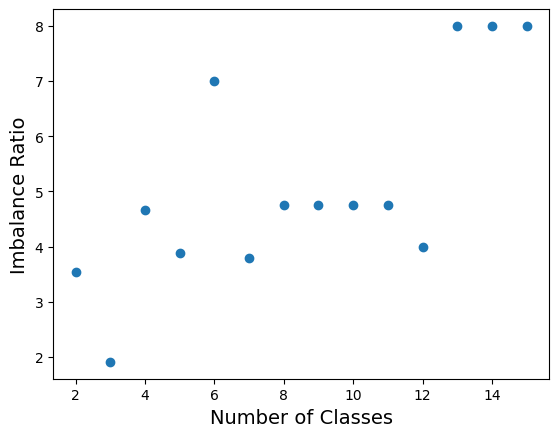

In [ ]:
# plot the results of the Jenks optimization based on IR (imbalance ratio)
fig = plt.figure()
plt.plot([t[0] for t in ir],
         [t[1] for t in ir],'o')
ax = plt.gca()
ax.set_xlabel('Number of Classes',fontsize=14)
ax.set_ylabel('Imbalance Ratio',fontsize=14)

Text(0.5, 0, 'Reservoir Temperature (°C)')

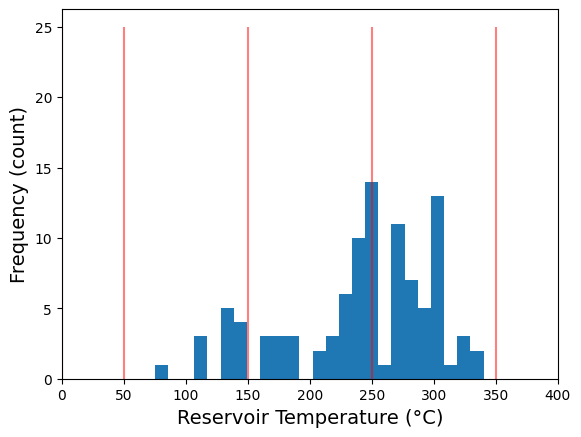

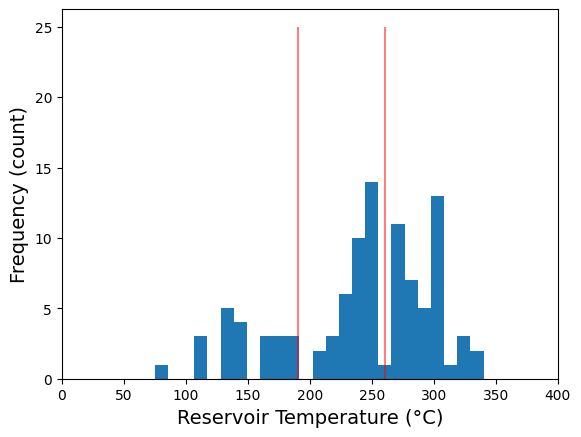

In [ ]:
# illustrate the split from brute force vs. using Jenks
plt.figure()
gdf['Reservoir temperature (°C)'].hist(density=False,bins=25,grid=False)
plt.xlim(0,400)
plt.vlines([0,50,150,250,350],0,25,colors='red',linestyles='solid',alpha=0.5)
plt.gca().set_ylabel('Frequency (count)',fontsize=14)
plt.gca().set_xlabel('Reservoir Temperature (°C)',fontsize=14)

plt.figure()
gdf['Reservoir temperature (°C)'].hist(density=False,bins=25,grid=False)
plt.xlim(0,400)
plt.vlines([190.0,260.385],0,25,colors='red',linestyles='solid',alpha=0.5)
plt.gca().set_ylabel('Frequency (count)',fontsize=14)
plt.gca().set_xlabel('Reservoir Temperature (°C)',fontsize=14)

### repeat optimized binning for other variables

In [ ]:
# look for best binning scheme for Latitude
ir = []
for i in range(10,37):
  breaks = jenkspy.jenks_breaks(gdf['Latitude'],n_classes=i)
  class_dist = pd.cut(gdf['Latitude'],bins=breaks,right=True,ordered=True,include_lowest=True).value_counts()
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

[(10, 8.666666666666666), (11, 8.666666666666666), (12, 13.0), (13, 7.0), (14, 7.0), (15, 7.0), (16, 14.0), (17, 14.0), (18, 14.0), (19, 14.0), (20, 13.0), (21, 13.0), (22, 11.0), (23, 11.0), (24, 11.0), (25, 11.0), (26, 11.0), (27, 11.0), (28, 11.0), (29, 11.0), (30, 11.0), (31, 11.0), (32, 10.0), (33, 10.0), (34, 10.0), (35, 10.0), (36, 9.0)]
optimal result:  (13, 7.0)


In [ ]:
breaks = jenkspy.jenks_breaks(gdf['Latitude'],n_classes=min_tuple[0])
print(breaks)
gdf['LatitudeBinned'] = pd.cut(gdf['Latitude'],bins=breaks,right=True,ordered=True,include_lowest=True)
gdf['LatitudeBinned']

[-38.6265737730077, -35.4174493901049, -3.12461602415685, 3.22713430821424, 11.1616256869209, 16.1272054141903, 21.1847883184437, 30.070529650180397, 33.28165921252375, 39.0015121911029, 40.9951430092967, 44.0224660255817, 52.5388118869164, 65.70449640725636]


,LatitudeBinned
0,"(11.162, 16.127]"
1,"(39.002, 40.995]"
2,"(33.282, 39.002]"
3,"(11.162, 16.127]"
4,"(39.002, 40.995]"
...,...
95,"(-35.417, -3.125]"
96,"(39.002, 40.995]"
97,"(30.071, 33.282]"
98,"(33.282, 39.002]"


In [ ]:
# look for best binning scheme for Longitude
ir = []
for i in range(5,37):
  breaks = jenkspy.jenks_breaks(gdf['Longitude'],n_classes=i)
  class_dist = pd.cut(gdf['Longitude'],bins=breaks,right=True,
                      ordered=True,include_lowest=True,duplicates='drop').value_counts()
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

[(5, 4.75), (6, 5.428571428571429), (7, 3.7142857142857144), (8, 13.0), (9, 12.0), (10, 12.0), (11, 24.0), (12, 24.0), (13, 23.0), (14, 23.0), (15, 23.0), (16, 14.0), (17, 14.0), (18, 14.0), (19, 14.0), (20, 14.0), (21, 14.0), (22, 14.0), (23, 14.0), (24, 14.0), (25, 9.0), (26, 9.0), (27, 9.0), (28, 9.0), (29, 9.0), (30, 9.0), (31, 9.0), (32, 9.0), (33, 9.0), (34, 9.0), (35, 9.0), (36, 9.0)]
optimal result:  (7, 3.7142857142857144)


In [ ]:
breaks = jenkspy.jenks_breaks(gdf['Longitude'],n_classes=min_tuple[0])
print(breaks)
gdf['LongitudeBinned'] = pd.cut(gdf['Longitude'],bins=breaks,right=True,ordered=True,include_lowest=True)
gdf['LongitudeBinned']

[-154.888784313872, -104.725634005348, -61.7690616794216, -16.77034536222635, 36.2905671744, 109.897662498048, 140.92043883964, 176.72102648633003]


,LongitudeBinned
0,"(-104.726, -61.769]"
1,"(-154.89000000000001, -104.726]"
2,"(-61.769, -16.77]"
3,"(109.898, 140.92]"
4,"(-154.89000000000001, -104.726]"
...,...
95,"(36.291, 109.898]"
96,"(-154.89000000000001, -104.726]"
97,"(109.898, 140.92]"
98,"(109.898, 140.92]"


In [ ]:
# fix missing commission years
gdf.loc[:,'FirstCommissionYear'] = [s if c == 9999 else c for s,c in zip(gdf['EstFirstYear'],gdf['FirstCommissionYear'])]

In [ ]:
# look for best binning scheme for Start Year
ir = []
for i in range(2,11):
  breaks = jenkspy.jenks_breaks(gdf['FirstCommissionYear'],n_classes=i)
  class_dist = pd.cut(gdf['FirstCommissionYear'],bins=breaks,right=True,duplicates='drop',ordered=True,include_lowest=True).value_counts()
  # print(class_dist)
  majorclass,minorclass = class_dist.max(),class_dist.min()
  ir.append((i,majorclass/minorclass))
print(ir)

# Find the tuple with the minimum second value
min_tuple = min(ir, key=lambda x: x[1])
print('optimal result: ', min_tuple)

[(2, 1.631578947368421), (3, 1.5384615384615385), (4, 3.0), (5, 2.727272727272727), (6, 9.333333333333334), (7, 9.0), (8, 7.333333333333333), (9, 5.666666666666667), (10, 5.666666666666667)]
optimal result:  (3, 1.5384615384615385)


In [ ]:
breaks = jenkspy.jenks_breaks(gdf['FirstCommissionYear'],n_classes=min_tuple[0])
print(breaks)
gdf['StartYearBinned'] = pd.cut(gdf['FirstCommissionYear'],bins=breaks,right=True,ordered=True,include_lowest=True, duplicates='drop')
gdf['StartYearBinned']

[1958.0, 1986.0, 2002.0, 2018.0]


,StartYearBinned
0,"(1957.999, 1986.0]"
1,"(1986.0, 2002.0]"
2,"(1986.0, 2002.0]"
3,"(1986.0, 2002.0]"
4,"(1986.0, 2002.0]"
...,...
95,"(1986.0, 2002.0]"
96,"(1957.999, 1986.0]"
97,"(1986.0, 2002.0]"
98,"(1986.0, 2002.0]"


# add columns from ECM-1 model

In [ ]:
ecm_orig

,Numb,Lon,Lat,Hcc,Sed,Hc,Type,DLy1,DLy2,DLy3,...,VP3,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON
0,1,-179.5,89.5,6.4459,2.3303,8.7762,SOCE,4.4574,6.5846,8.7762,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
1,2,-178.5,89.5,6.3511,2.3344,8.6854,SOCE,4.4302,6.5261,8.6854,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
2,3,-177.5,89.5,6.2512,2.3398,8.5910,SOCE,4.4027,6.4656,8.5910,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
3,4,-176.5,89.5,6.1516,2.3463,8.4980,SOCE,4.3764,6.4064,8.4980,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
4,5,-175.5,89.5,6.0578,2.3520,8.4098,SOCE,4.3510,6.3501,8.4098,...,6.739467,3.217479,3.441446,3.807608,8.028349,4.467863,2.654495,2.736552,2.895387,3.301104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,64796,175.5,-89.5,39.0010,0.0000,39.0010,PLAT,12.8703,25.7406,39.0010,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778
64796,64797,176.5,-89.5,39.0014,0.0000,39.0014,PLAT,12.8705,25.7409,39.0014,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778
64797,64798,177.5,-89.5,39.0018,0.0000,39.0018,PLAT,12.8706,25.7412,39.0018,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778
64798,64799,178.5,-89.5,39.0023,0.0000,39.0023,PLAT,12.8708,25.7415,39.0023,...,6.909733,3.572958,3.766211,3.959193,8.127480,4.538286,2.752636,2.842270,2.942304,3.336778


In [ ]:
# Create the interpolating function
latitudes  = ecm_orig['Lat'].unique()
longitudes = ecm_orig['Lon'].unique()

In [ ]:
# save off crystalline crustal thickness
values = ecm_orig['Hcc'].values.reshape(len(latitudes), len(longitudes))
interp_hcc = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'CCrustThick'] = [interp_hcc([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]

<Axes: >

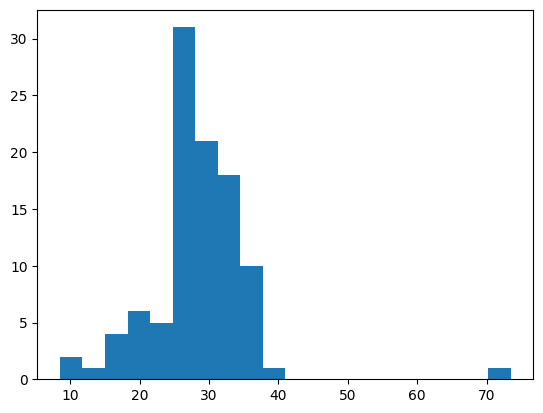

In [ ]:
gdf.CCrustThick.hist(density=False,bins=20,grid=False)

<Axes: >

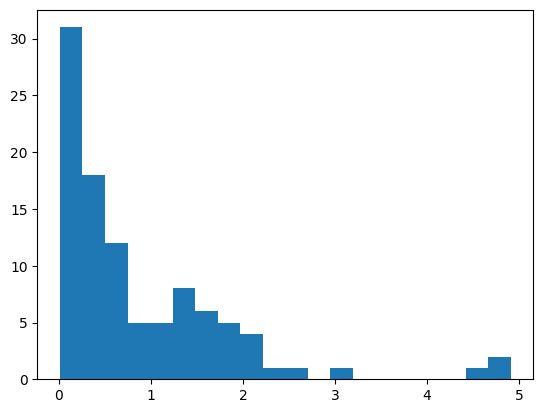

In [ ]:
# save off sediment thickness
values = ecm_orig['Sed'].values.reshape(len(latitudes), len(longitudes))
interp_sed = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'SedThick'] = [interp_sed([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.SedThick.hist(density=False,bins=20,grid=False)

In [ ]:
# capture all velocity and density profiles from the earth model
for var in ['VP1','VP2','VP3', 'VS1', 'VS2','VS3', 'VPN', 'VSN', 'RHO1', 'RHO2', 'RHO3', 'RHON']:
  values = ecm_orig[var].values.reshape(len(latitudes), len(longitudes))
  interp_var = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
  gdf.loc[:,var] = [interp_var([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]

<Axes: >

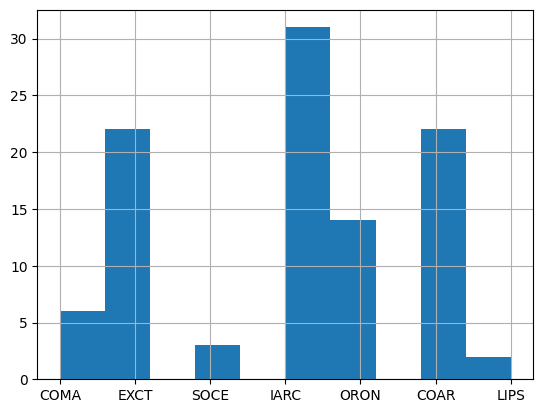

In [ ]:
# add crust type
values = ecm_orig['Type'].values.reshape(len(latitudes), len(longitudes))
def lookupstring(lat,lon) -> str:
  distances = np.sqrt((ecm_orig['Lat'] - lat)**2 +
                      (ecm_orig['Lon'] - lon)**2)

  closest_idx = distances.idxmin()
  return ecm_orig.loc[closest_idx,'Type']
gdf.loc[:,'CrustType'] = [lookupstring(lat,lon) for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.CrustType.hist()

In [ ]:
# look for nonsense assignments, like Continental Margin
gdf[gdf.CrustType == 'COMA']

,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime,Country_x,PowerPlant,Latitude,Longitude,Elevation,MatchName_x,...,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON,CrustType
0,Ahuachapan,250.0,14.420000,Arcs,Central_America,Ahuachapan,13.920160,-89.817176,798.0,Ahuachapan,...,3.442918,3.696252,3.798166,7.983980,4.509142,2.716547,2.840780,2.896375,3.285388,COMA
32,Lahendong,280.0,18.395062,Arcs,Indonesia_PapuaNG,Lahendong,1.263046,124.829006,877.0,Lahendong,...,3.430523,3.674885,3.784942,8.003229,4.456010,2.713712,2.835852,2.885495,3.292219,COMA
34,Las Pailas,245.0,9.506173,Arcs,Central_America,Las Pailas,10.757375,-85.359321,642.0,Las Pailas,...,3.441879,3.692815,3.797458,7.992317,4.499714,2.715464,2.837182,2.891326,3.288337,COMA
36,Lihir,220.0,15.802469,Arcs,Indonesia_PapuaNG,Lihir,-3.124616,152.646337,5.0,Lihir,...,3.338205,3.572075,3.797208,8.025604,4.477269,2.684007,2.785906,2.881249,3.300124,COMA
42,Mataloko,240.0,2.345679,Arcs,Indonesia_PapuaNG,Mataloko,-8.833641,121.060828,1038.0,Mataloko,...,3.419284,3.665180,3.782285,7.986440,4.431217,2.716964,2.841519,2.899468,3.286294,COMA
44,Miravalles,236.0,17.283951,Arcs,Central_America,Miravalles,10.709141,-85.187714,660.0,Miravalles,...,3.440716,3.693352,3.800269,7.985843,4.500076,2.716846,2.838210,2.896505,3.286045,COMA


In [ ]:
# fix designations
gdf.set_index('Name',inplace=True)

# PapuaNG is island arc
gdf.loc['Mataloko','CrustType']   = 'IARC'
gdf.loc['Lihir','CrustType']      = 'IARC'
gdf.loc['Lahendong','CrustType']  = 'IARC'

# Central American volcanism is Continental Arc
gdf.loc['Las Pailas','CrustType'] = 'CARC'
gdf.loc['Miravalles','CrustType'] = 'CARC'
gdf.loc['Ahuachapan','CrustType'] = 'CARC'

gdf.reset_index(drop=False,inplace=True)

# look for nonsense assignments, like Continental Margin
gdf[gdf.CrustType == 'COMA']

,Name,WS_Temp,WS_PowerDensity,WS_TectonicRegime,Country_x,PowerPlant,Latitude,Longitude,Elevation,MatchName_x,...,VS1,VS2,VS3,VPN,VSN,RHO1,RHO2,RHO3,RHON,CrustType


### Add Crustal Thickness Gradient from horizontal gradient applied to Hcc (crystalline crust)

In [ ]:
gct_orig

,Longitude,Latitude,Gradient
0,-179.50,-89.5,1.807161
1,-179.25,-89.5,1.961738
2,-179.00,-89.5,1.967465
3,-178.75,-89.5,1.948373
4,-178.50,-89.5,1.903459
...,...,...,...
1030324,178.50,89.5,1.028454
1030325,178.75,89.5,1.103621
1030326,179.00,89.5,1.221283
1030327,179.25,89.5,1.390467


<Axes: >

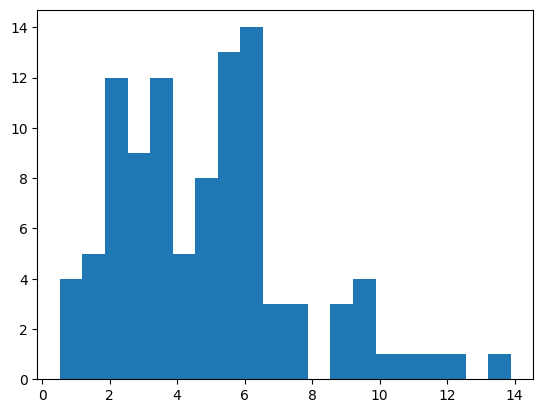

In [ ]:
latitudes  = gct_orig['Latitude'].unique()
longitudes = gct_orig['Longitude'].unique()
values = gct_orig['Gradient'].values.reshape(len(latitudes), len(longitudes))

interp_gct = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'GradHcc'] = [interp_gct([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.GradHcc.hist(density=False,bins=20,grid=False)

## Add Heat Flow from Lucazeau, 2019 Model

<Axes: >

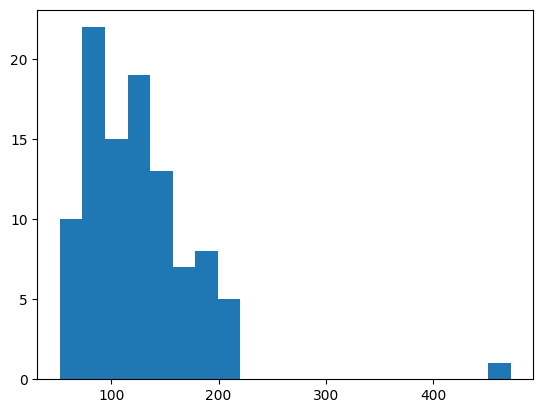

In [ ]:
hf_orig.columns = ['Longitude','Latitude','HF_pred','sHF_pred','HF_obs']

latitudes  = hf_orig['Latitude'].unique()
longitudes = hf_orig['Longitude'].unique()
values = hf_orig['HF_pred'].values.reshape(len(latitudes), len(longitudes))

interp_hf = RegularGridInterpolator((latitudes, longitudes), values, method='linear')
gdf.loc[:,'HeatFlow'] = [interp_hf([lat,lon])[0] for lat,lon in zip(gdf.Latitude,gdf.Longitude)]
gdf.HeatFlow.hist(density=False,bins=20,grid=False)

In [ ]:
gdf.columns

Index(['Name', 'WS_Temp', 'WS_PowerDensity', 'WS_TectonicRegime', 'Country_x',
       'PowerPlant', 'Latitude', 'Longitude', 'Elevation', 'MatchName_x',
       'CountryShort', 'CountryLong', 'GPPDBName', 'NameplateCapacity',
       'GPPDBLatitude', 'GPPDBLongitude', 'FirstCommissionYear', 'Owner',
       'EstGenerationPerYear', 'MatchName_y', 'Country_y', 'Asset',
       'RystadLatitude', 'RystadLongitude', 'Temperature',
       'Reservoir temperature (°C)', 'Startup year',
       'Installed capacity (MWe)', 'Production wells', 'Total wells',
       'Drilling length group (meters)', 'MW per well', 'PowerPerWell',
       'EstFirstYear', 'WorldClim_AvgTemp', 'WorldClim_MinTemp',
       'WorldClim_MaxTemp', 'WorldClim_AvgPrec', 'WorldClim_TempRange',
       'PDTemp_Edited', 'Geography', 'ResTempBinned', 'LatitudeBinned',
       'LongitudeBinned', 'StartYearBinned', 'CCrustThick', 'SedThick', 'VP1',
       'VP2', 'VP3', 'VS1', 'VS2', 'VS3', 'VPN', 'VSN', 'RHO1', 'RHO2', 'RHO3',
       'RHO

In [ ]:
# discritize earth model variables
# capture all velocity and density profiles from the earth model
for var in ['VP1','VP2','VP3','VS1','VS2','VS3','VPN','VSN','RHO1','RHO2','RHO3','RHON','HeatFlow']:
  print(var)
  # look for best binning scheme for Start Year
  ir = []
  for i in range(3,10):
    breaks = jenkspy.jenks_breaks(gdf[var],n_classes=i)
    class_dist = pd.cut(gdf[var],bins=breaks,right=True,duplicates='drop',ordered=True,include_lowest=True).value_counts()
    majorclass,minorclass = class_dist.max(),class_dist.min()
    ir.append((i,majorclass/minorclass))

  print(ir)
  # Find the tuple with the minimum second value
  min_tuple = min(ir, key=lambda x: x[1])
  print('optimal result: ', min_tuple)

  breaks = jenkspy.jenks_breaks(gdf[var],n_classes=min_tuple[0])
  print(breaks)
  gdf[f'{var}Binned'] = pd.cut(gdf[var],bins=breaks,right=True,ordered=True,include_lowest=True,duplicates='drop')

VP1
[(3, 22.75), (4, 22.333333333333332), (5, 20.333333333333332), (6, 15.0), (7, 45.0), (8, 45.0), (9, 37.0)]
optimal result:  (6, 15.0)
[5.671926940999999, 5.694938089, 5.919813112127967, 6.007240432141366, 6.0341481368104715, 6.059932661953624, 6.080603692]
VP2
[(3, 8.833333333333334), (4, 9.6), (5, 5.8), (6, 9.666666666666666), (7, 8.333333333333334), (8, 7.0), (9, 7.0)]
optimal result:  (5, 5.8)
[6.091359729, 6.264378011382193, 6.4190186328480365, 6.519842818250732, 6.604419690044504, 6.649665988]
VP3
[(3, 1.9583333333333333), (4, 3.0714285714285716), (5, 2.2857142857142856), (6, 9.666666666666666), (7, 9.666666666666666), (8, 9.666666666666666), (9, 8.666666666666666)]
optimal result:  (3, 1.9583333333333333)
[6.686222225026055, 6.8204572951644655, 6.9350413582182835, 7.018598114000001]
VS1
[(3, 10.5), (4, 8.0), (5, 8.0), (6, 8.0), (7, 20.0), (8, 13.5), (9, 13.5)]
optimal result:  (4, 8.0)
[3.2044784979999994, 3.2174791460000005, 3.3803703077661513, 3.4206055787813248, 3.45421200

### create label encodings for values

In [ ]:
# down-select to only the columns to test (and rename them)
keepcols = ['Name','CountryLong','Geography','WS_Temp','PDTemp_Edited',
            'Reservoir temperature (°C)','ResTempBinned','WS_PowerDensity','WS_TectonicRegime',
            'Latitude','Longitude','LatitudeBinned','LongitudeBinned',
            'Elevation','Startup year','StartYearBinned','Installed capacity (MWe)',
            'Production wells','Total wells','Drilling length group (meters)','PowerPerWell',
            'WorldClim_AvgTemp','WorldClim_MinTemp','WorldClim_MaxTemp','WorldClim_TempRange',
            'WorldClim_AvgPrec','CCrustThick','SedThick','VP1',
            'VP2','VP3','VS1','VS2',
            'VS3','VPN','VSN','RHO1',
            'RHO2','RHO3','RHON','CrustType',
            'GradHcc','HeatFlow','VP1Binned','VP2Binned',
            'VP3Binned','VS1Binned','VS2Binned','VS3Binned',
            'VPNBinned','VSNBinned','RHO1Binned','RHO2Binned',
            'RHO3Binned','RHONBinned','HeatFlowBinned']
colnames = ['Name','Country','Region','PDTemp','PDTemp_Edited',
            'ResTemp','ResTempBinned','PDPowerDensity','TectonicSetting',
            'LatitudeDegree','LongitudeDegree','LatitudeBinned','LongitudeBinned',
            'Elevation','StartYear','StartYearBinned','NameplateCapacity',
            'ProdWellCount','TotWellCount','DrillLengthBinned','PowerPerWell',
            'AvgAmbientTemp','MinAmbientTemp','MaxAmbientTemp','AmbientTempRange',
            'AvgPrecipitation','CCrustThick','SedThick','VP1',
            'VP2','VP3','VS1','VS2',
            'VS3','VPN','VSN','RHO1',
            'RHO2','RHO3','RHON','CrustType',
            'GradCCrustThick','HeatFlow','VP1Binned','VP2Binned',
            'VP3Binned','VS1Binned','VS2Binned','VS3Binned',
            'VPNBinned','VSNBinned','RHO1Binned','RHO2Binned',
            'RHO3Binned','RHONBinned','HeatFlowBinned']
gdf = gdf[keepcols]
gdf.columns = colnames

In [ ]:
# start with ordinal encoding any binned variables that are ordered
numcols = gdf.select_dtypes(include=['int64', 'float64']).columns
ordcols = [c for c in gdf.select_dtypes(include=['category','object']).columns if 'Binned' in c ]
labcols = [c for c in gdf.select_dtypes(include=['category','object']).columns if 'Binned' not in c]

print(numcols, ordcols, labcols)

Index(['PDTemp', 'PDTemp_Edited', 'ResTemp', 'PDPowerDensity',
       'LatitudeDegree', 'LongitudeDegree', 'Elevation', 'StartYear',
       'NameplateCapacity', 'ProdWellCount', 'TotWellCount', 'PowerPerWell',
       'AvgAmbientTemp', 'MinAmbientTemp', 'MaxAmbientTemp',
       'AmbientTempRange', 'AvgPrecipitation', 'CCrustThick', 'SedThick',
       'VP1', 'VP2', 'VP3', 'VS1', 'VS2', 'VS3', 'VPN', 'VSN', 'RHO1', 'RHO2',
       'RHO3', 'RHON', 'GradCCrustThick', 'HeatFlow'],
      dtype='object') ['ResTempBinned', 'LatitudeBinned', 'LongitudeBinned', 'StartYearBinned', 'DrillLengthBinned', 'VP1Binned', 'VP2Binned', 'VP3Binned', 'VS1Binned', 'VS2Binned', 'VS3Binned', 'VPNBinned', 'VSNBinned', 'RHO1Binned', 'RHO2Binned', 'RHO3Binned', 'RHONBinned', 'HeatFlowBinned'] ['Name', 'Country', 'Region', 'TectonicSetting', 'CrustType']


In [ ]:
# encode ordinal values, one-hot encode label values
gdfenc = gdf.copy(deep=True)

# keep track of any encodings
encoders = {}

# encode ordinal values first
for c in ordcols:
  print(c)
  oe = OrdinalEncoder()
  gdfenc[c] = oe.fit_transform(gdfenc[[c]])
  encoders[c] = oe

# now take care of labelled items (except Name)
for c in labcols:
  if (c == 'Name') | (c == 'Country'):
    continue

  # replace with one hot encoding
  onehot = pd.get_dummies(gdfenc[c])
  gdfenc = pd.concat([gdfenc.drop([c],axis=1),onehot],axis=1)

# reset column lists
boolcols = gdfenc.select_dtypes(include=['bool']).columns
numcols  = gdfenc.select_dtypes(include=['int64', 'float64']).columns
labcols  = gdfenc.select_dtypes(include=['category', 'object']).columns
print(boolcols)
print(numcols)
print(labcols)

ResTempBinned
LatitudeBinned
LongitudeBinned
StartYearBinned
DrillLengthBinned
VP1Binned
VP2Binned
VP3Binned
VS1Binned
VS2Binned
VS3Binned
VPNBinned
VSNBinned
RHO1Binned
RHO2Binned
RHO3Binned
RHONBinned
HeatFlowBinned
Index(['Africa', 'Central America', 'East Asia', 'Eurasia', 'Europe',
       'North America', 'North Asia', 'Oceania', 'Southeast Asia', 'Arcs',
       'Fault-Based', 'Other', 'Rifts', 'CARC', 'COAR', 'EXCT', 'IARC', 'LIPS',
       'ORON', 'SOCE'],
      dtype='object')
Index(['PDTemp', 'PDTemp_Edited', 'ResTemp', 'ResTempBinned', 'PDPowerDensity',
       'LatitudeDegree', 'LongitudeDegree', 'LatitudeBinned',
       'LongitudeBinned', 'Elevation', 'StartYear', 'StartYearBinned',
       'NameplateCapacity', 'ProdWellCount', 'TotWellCount',
       'DrillLengthBinned', 'PowerPerWell', 'AvgAmbientTemp', 'MinAmbientTemp',
       'MaxAmbientTemp', 'AmbientTempRange', 'AvgPrecipitation', 'CCrustThick',
       'SedThick', 'VP1', 'VP2', 'VP3', 'VS1', 'VS2', 'VS3', 'VPN', 'VSN',
  

In [ ]:
# list out encodings
for e in encoders.keys():
  print(e)
  if isinstance(encoders[e], OrdinalEncoder):
    print(encoders[e].categories_)
  else:
    print(encoders[e].classes_)

ResTempBinned
[array([Interval(74.999, 190.0, closed='right'),
       Interval(190.0, 260.0, closed='right'),
       Interval(260.0, 340.0, closed='right')], dtype=object)]
LatitudeBinned
[array([Interval(-38.628, -35.417, closed='right'),
       Interval(-35.417, -3.125, closed='right'),
       Interval(-3.125, 3.227, closed='right'),
       Interval(3.227, 11.162, closed='right'),
       Interval(11.162, 16.127, closed='right'),
       Interval(16.127, 21.185, closed='right'),
       Interval(21.185, 30.071, closed='right'),
       Interval(30.071, 33.282, closed='right'),
       Interval(33.282, 39.002, closed='right'),
       Interval(39.002, 40.995, closed='right'),
       Interval(40.995, 44.022, closed='right'),
       Interval(44.022, 52.539, closed='right'),
       Interval(52.539, 65.704, closed='right')], dtype=object)]
LongitudeBinned
[array([Interval(-154.89000000000001, -104.726, closed='right'),
       Interval(-104.726, -61.769, closed='right'),
       Interval(-61.769,

### save out all data engineering work

In [ ]:
# save off both an excel version and raw data one (to preserve categoricals)
gdf.to_excel(dirpath / 'Output' / 'gdf_complete_FIELDS.xlsx')

# save dataFrames and dictionary to a pickle file
with open(dirpath / 'Output' / 'gdf_complete_FIELDS.pkl', 'wb') as f:
    pkl.dump((gdf, gdfenc, encoders), f)

# # Load dataFrames and dictionary from a pickle file
# with open(dirpath / 'Output' / 'gdf_complete_FIELDS.pkl', 'rb') as f:
#     gdf, gdfenc, encoders = pkl.load(f)